In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates

## Downloading the Raw Dataset

In [49]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-10-2021.csv')

In [9]:
confirmed_df.shape

(275, 480)

In [10]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146


## Loading the dataset and Extracting the date list

In [11]:
confirmed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/2/21', '5/3/21', '5/4/21', '5/5/21', '5/6/21', '5/7/21', '5/8/21',
       '5/9/21', '5/10/21', '5/11/21'],
      dtype='object', length=480)

In [12]:
confirmed_df.columns[4:]

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '5/2/21', '5/3/21', '5/4/21', '5/5/21', '5/6/21', '5/7/21', '5/8/21',
       '5/9/21', '5/10/21', '5/11/21'],
      dtype='object', length=476)

In [14]:
cols = confirmed_df.keys()
dates = confirmed_df.loc[:, cols[4]:cols[-1]].keys()

## Merging the confirmed_df, deaths_df and recovered_df

In [15]:
date_values = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=date_values, 
    var_name='Date', 
    value_name='Recovered'
)

### Converting to new long DataFrames. 
### All of them are ordered by Date and Country/Region because raw data was already ordered by Country/Region and the date columns are already in ASC order.

In [16]:
confirmed_df_long.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


### Canada recovered data is counted by Country-wise rather than Province/State-wise [dropping it]

In [17]:
canada_recoverd_data = recovered_df_long[recovered_df_long['Country/Region']=='Canada']

In [18]:
canada_recoverd_data.head()

,Province/State,Country/Region,Lat,Long,Date,Recovered
39,NaN,Canada,56.1304,-106.3468,1/22/20,0
299,NaN,Canada,56.1304,-106.3468,1/23/20,0
559,NaN,Canada,56.1304,-106.3468,1/24/20,0
819,NaN,Canada,56.1304,-106.3468,1/25/20,0
1079,NaN,Canada,56.1304,-106.3468,1/26/20,0


In [19]:
recovered_df_long = recovered_df_long[recovered_df_long['Country/Region']!='Canada']

### Mergint the 3 dataframes

In [20]:
# Merging confirmed_df_long and deaths_df_long
full_table = confirmed_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
# Merging full_table and recovered_df_long
full_table = full_table.merge(
  right=recovered_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

In [21]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0,0,0.0
1,NaN,Albania,41.15330,20.168300,1/22/20,0,0,0.0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0,0,0.0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0,0,0.0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0,0,0.0


### Data Cleaning

#### Handling the date values

In [22]:
full_table['Date'] = pd.to_datetime(full_table['Date'])

In [23]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0.0
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0.0
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0.0
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0.0
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0.0


#### Detecting the missing values

In [24]:
full_table.isna().sum()

Province/State    89964
Country/Region        0
Lat                 952
Long                952
Date                  0
Confirmed             0
Deaths                0
Recovered          9996
dtype: int64

In [25]:
full_table['Recovered'] = full_table['Recovered'].fillna(0)

#### Ship data needs to be filtered out

In [26]:
# cruise ships: Grand Princess, Diamond Princess and MS Zaandam
full_table[full_table['Country/Region'] == 'Diamond Princess']

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
105,NaN,Diamond Princess,0.0,0.0,2020-01-22,0,0,0.0
380,NaN,Diamond Princess,0.0,0.0,2020-01-23,0,0,0.0
655,NaN,Diamond Princess,0.0,0.0,2020-01-24,0,0,0.0
930,NaN,Diamond Princess,0.0,0.0,2020-01-25,0,0,0.0
1205,NaN,Diamond Princess,0.0,0.0,2020-01-26,0,0,0.0
...,...,...,...,...,...,...,...,...
129630,NaN,Diamond Princess,0.0,0.0,2021-05-07,712,13,699.0
129905,NaN,Diamond Princess,0.0,0.0,2021-05-08,712,13,699.0
130180,NaN,Diamond Princess,0.0,0.0,2021-05-09,712,13,699.0
130455,NaN,Diamond Princess,0.0,0.0,2021-05-10,712,13,699.0


#### Extracting the ship data and deleting from original data

In [27]:
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')
full_ship = full_table[ship_rows]

In [28]:
full_table = full_table[~(ship_rows)]

#### Data aggregation (Calculating the Active cases column)

In [29]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

In [30]:
full_table

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
130895,NaN,Vietnam,14.058324,108.277199,2021-05-11,3571,35,2618.0,918.0
130896,NaN,West Bank and Gaza,31.952200,35.233200,2021-05-11,302777,3393,287932.0,11452.0
130897,NaN,Yemen,15.552727,48.516388,2021-05-11,6492,1276,3003.0,2213.0
130898,NaN,Zambia,-13.133897,27.849332,2021-05-11,92152,1258,90539.0,355.0


####  Aggregating data into Country/Region wise and group them by Date and Country/Region

In [31]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [32]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0.0,0.0
1,2020-01-22,Albania,0,0,0.0,0.0
2,2020-01-22,Algeria,0,0,0.0,0.0
3,2020-01-22,Andorra,0,0,0.0,0.0
4,2020-01-22,Angola,0,0,0.0,0.0
...,...,...,...,...,...,...
90435,2021-05-11,Vietnam,3571,35,2618.0,918.0
90436,2021-05-11,West Bank and Gaza,302777,3393,287932.0,11452.0
90437,2021-05-11,Yemen,6492,1276,3003.0,2213.0
90438,2021-05-11,Zambia,92152,1258,90539.0,355.0


#### add day wise New cases, New deaths and New recovered by deducting the corresponding accumulative data on the previous day.

In [33]:
# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])
# filling na with 0
full_grouped = full_grouped.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')
# 
full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

In [34]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
0,2020-01-22,Afghanistan,0,0,0.0,0.0,0,0,0
1,2020-01-22,Albania,0,0,0.0,0.0,0,0,0
2,2020-01-22,Algeria,0,0,0.0,0.0,0,0,0
3,2020-01-22,Andorra,0,0,0.0,0.0,0,0,0
4,2020-01-22,Angola,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...
90435,2021-05-11,Vietnam,3571,35,2618.0,918.0,82,0,0
90436,2021-05-11,West Bank and Gaza,302777,3393,287932.0,11452.0,528,15,726
90437,2021-05-11,Yemen,6492,1276,3003.0,2213.0,7,1,2
90438,2021-05-11,Zambia,92152,1258,90539.0,355.0,40,1,38


In [35]:
full_grouped.to_csv('COVID-19-time-series-clean-complete.csv')

## Data Exploration

### Country wise corona virus spread

In [36]:
import pandas as pd
import altair as alt
full_grouped = pd.read_csv('COVID-19-time-series-clean-complete.csv', parse_dates=['Date'])

In [37]:
full_grouped = pd.read_csv('COVID-19-time-series-clean-complete.csv', parse_dates=['Date'])
countries = ['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'India', 'United Kingdom', 'Switzerland']
selected_countries = full_grouped[full_grouped['Country/Region'].isin(countries)]

In [38]:
selected_countries

,Unnamed: 0,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
36,36,2020-01-22,China,548,17,28.0,503.0,0,0,0
61,61,2020-01-22,France,0,0,0.0,0.0,0,0,0
65,65,2020-01-22,Germany,0,0,0.0,0.0,0,0,0
78,78,2020-01-22,India,0,0,0.0,0.0,0,0,0
84,84,2020-01-22,Italy,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
90334,90334,2021-05-11,Italy,4123230,123282,3636089.0,363859.0,6943,251,16503
90410,90410,2021-05-11,Spain,3586333,79100,150376.0,3356857.0,4941,205,0
90415,90415,2021-05-11,Switzerland,675671,10721,317600.0,347350.0,1375,6,0
90426,90426,2021-05-11,US,32778374,582834,0.0,32195540.0,33119,681,0


In [39]:
alt.Chart(selected_countries).mark_circle().encode(
    x='yearmonthdate(Date):O',
    y='Country/Region',
    color='Country/Region',
    size=alt.Size('New cases:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Daily new cases')
    ) 
).properties(
    width=800,
    height=300
)

alt.Chart(...)

### India recent analysis

In [40]:
india = full_grouped[full_grouped['Country/Region'] == 'India']

In [41]:
base = alt.Chart(india).mark_bar().encode(
    x='yearmonthdate(Date):O',
).properties(
    width=500
)

In [42]:
red = alt.value("#f54242")
base.encode(y='Confirmed').properties(title='Total confirmed')

alt.Chart(...)

In [43]:
base.encode(y='Deaths', color=red).properties(title='Total Deaths')

alt.Chart(...)

In [44]:
red = alt.value("#f54242")
base.encode(y='New cases').properties(title='Daily new cases')

alt.Chart(...)

In [45]:
base.encode(y='New deaths', color=red).properties(title='Daily new deaths')

alt.Chart(...)

In [46]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

In [47]:
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
#     country_recoveries = []  
    
    for i in date_values:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
#         country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths)

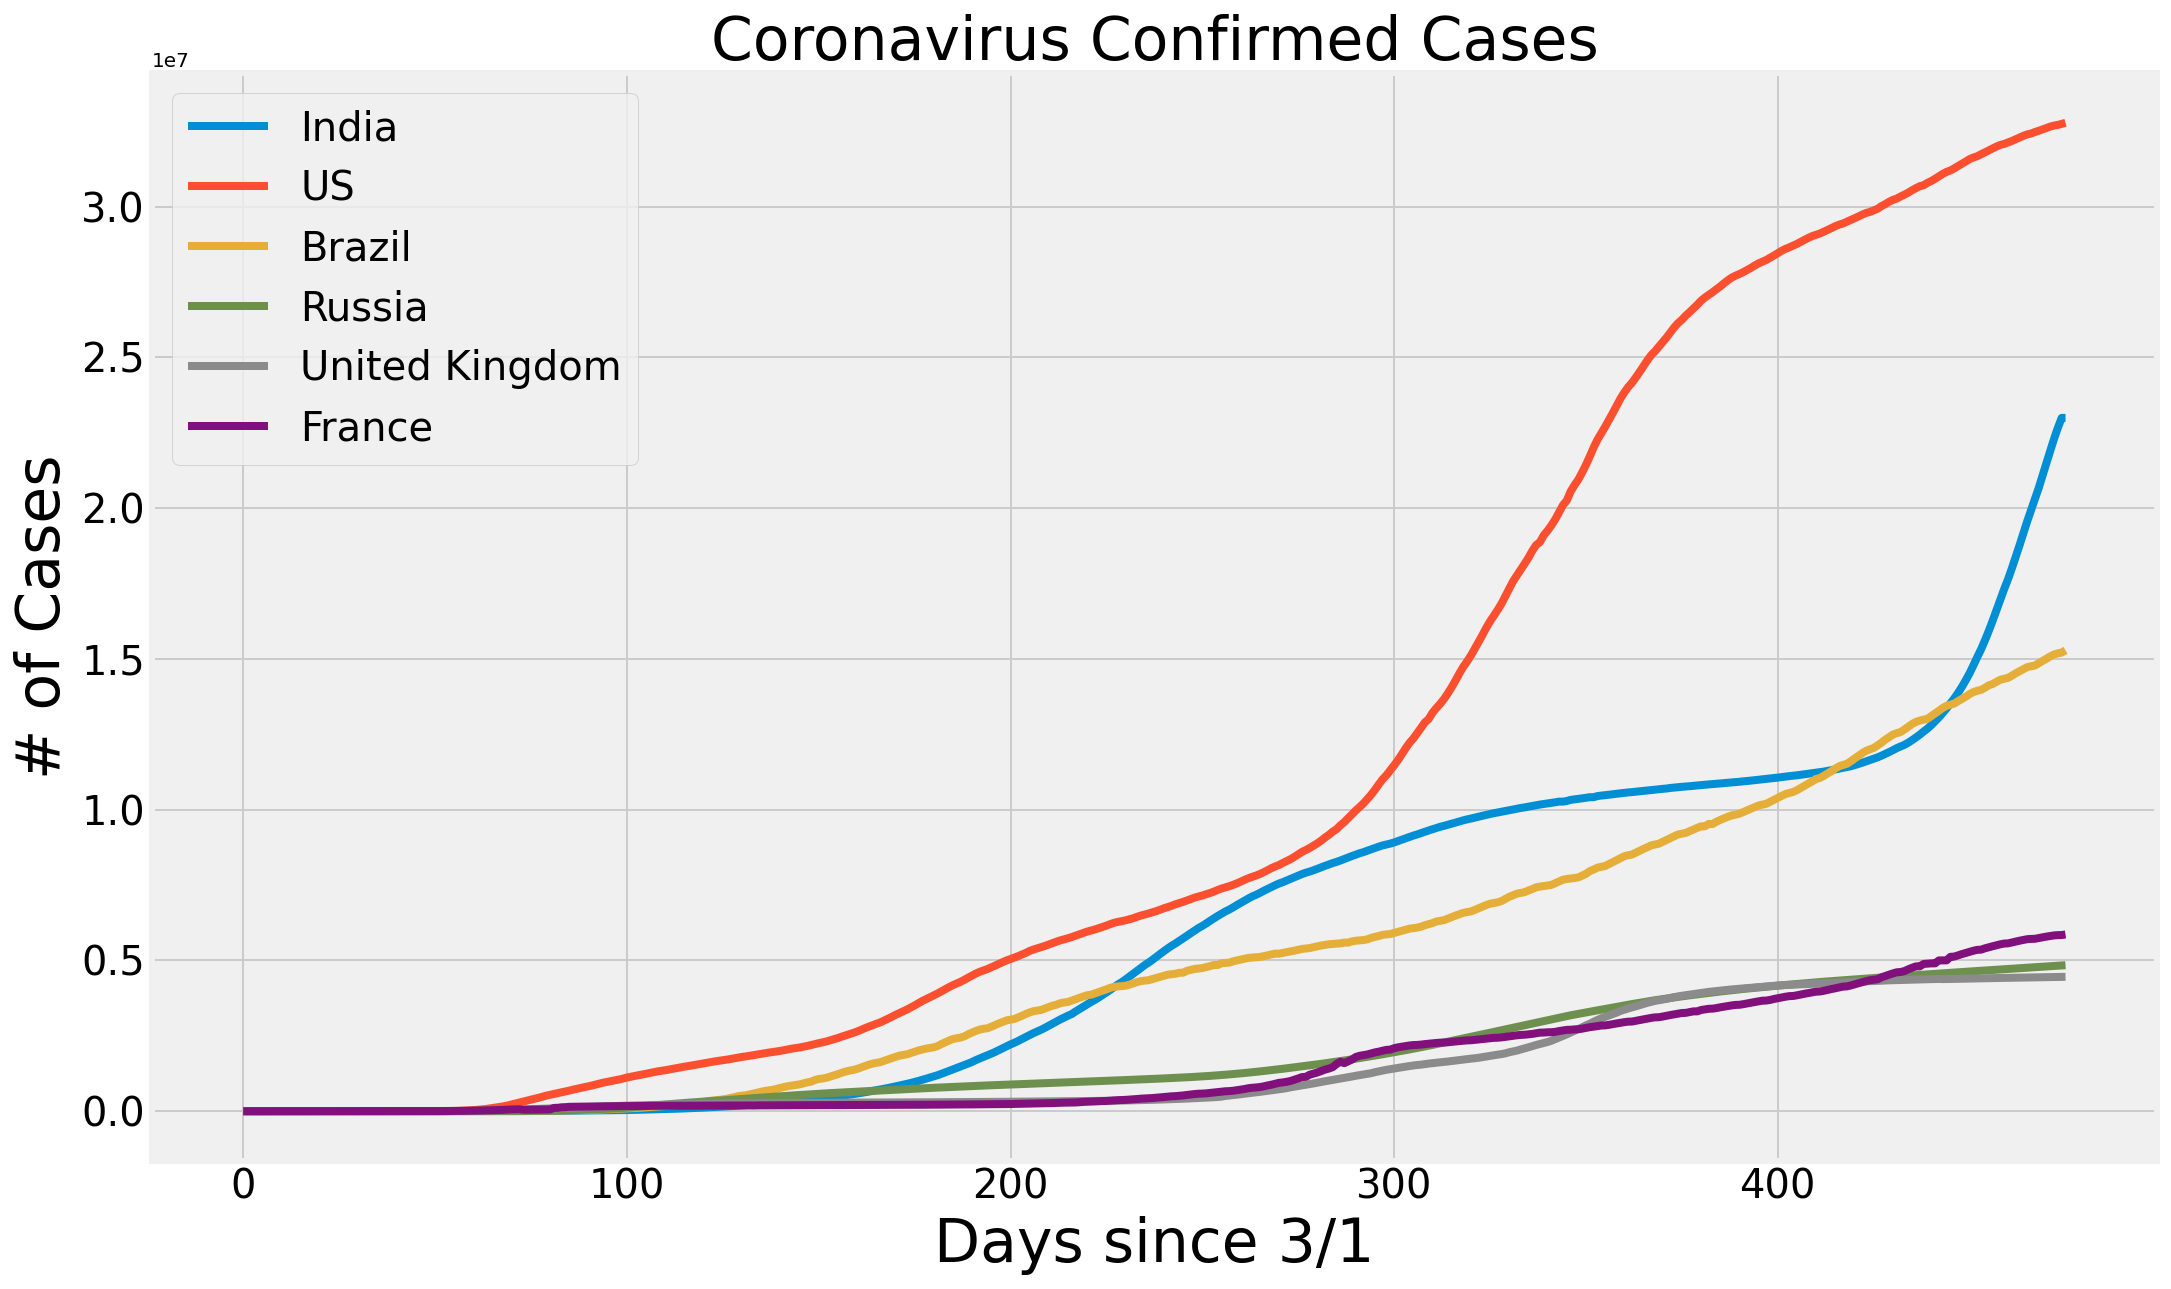

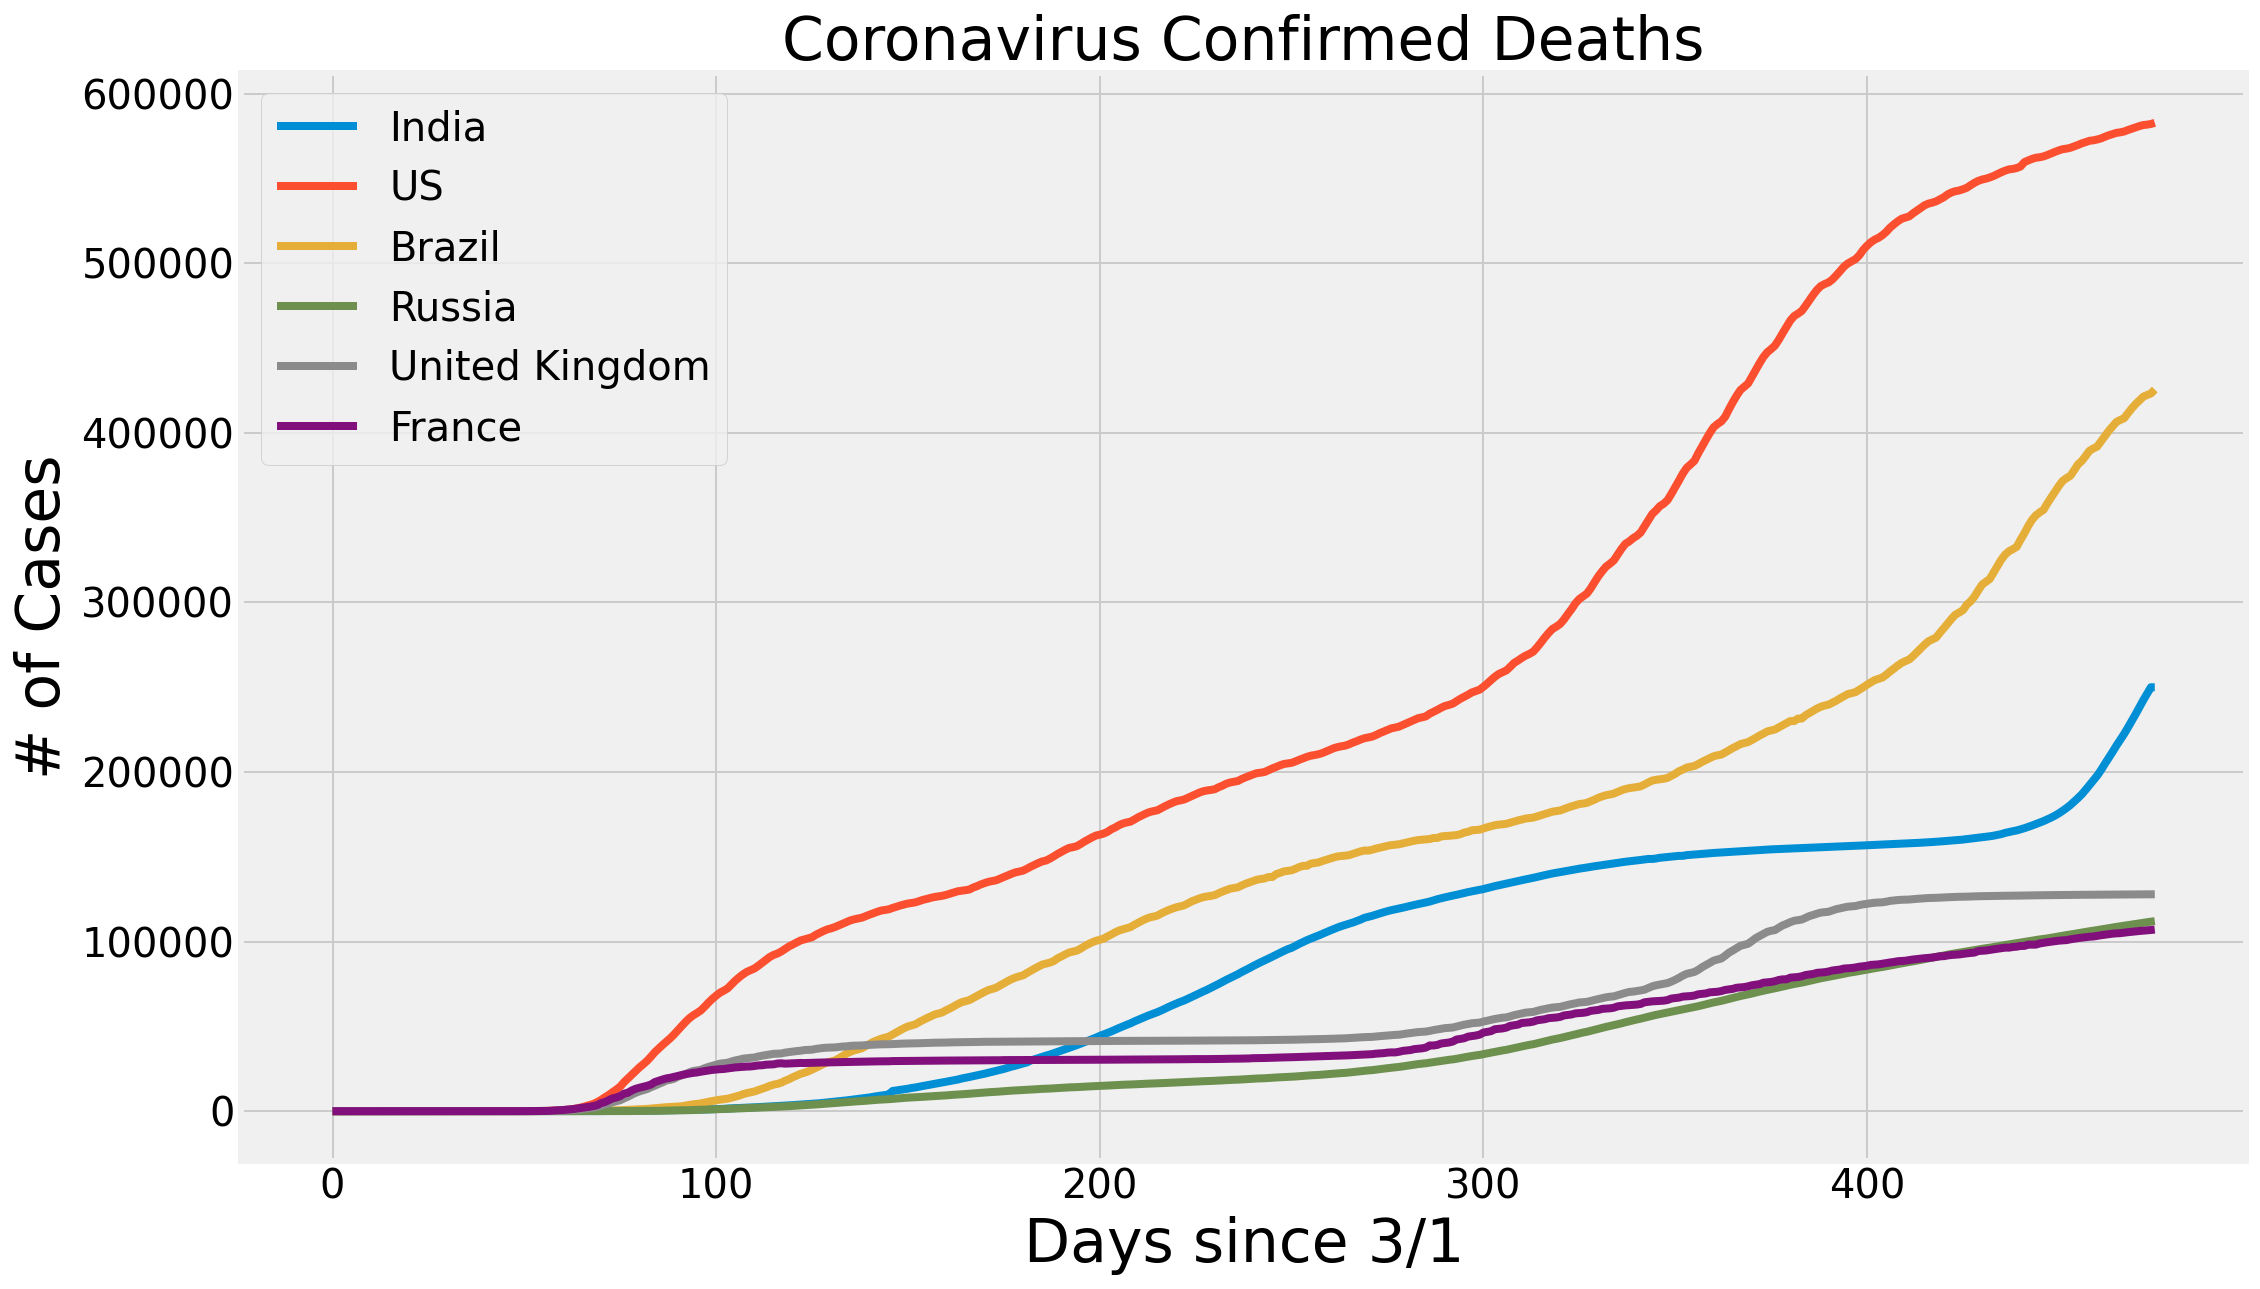

In [48]:
compare_countries = ['India', 'US', 'Brazil', 'Russia', 'United Kingdom', 'France'] 
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Confirmed Deaths']

for num in range(2):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 3/1', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [50]:
latest_data

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-05-11 04:20:41,33.939110,67.709953,62063,2698,54382.0,4983.0,Afghanistan,159.428834,4.347196
1,NaN,NaN,NaN,Albania,2021-05-11 04:20:41,41.153300,20.168300,131753,2416,118041.0,11296.0,Albania,4578.254222,1.833734
2,NaN,NaN,NaN,Algeria,2021-05-11 04:20:41,28.033900,1.659600,124288,3335,86554.0,34399.0,Algeria,283.432255,2.683284
3,NaN,NaN,NaN,Andorra,2021-05-11 04:20:41,42.506300,1.521800,13429,127,13021.0,281.0,Andorra,17380.443927,0.945714
4,NaN,NaN,NaN,Angola,2021-05-11 04:20:41,-11.202700,17.873900,28875,636,24772.0,3467.0,Angola,87.856035,2.202597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,NaN,NaN,NaN,Vietnam,2021-05-11 04:20:41,14.058324,108.277199,3489,35,2618.0,836.0,Vietnam,3.584396,1.003153
3979,NaN,NaN,NaN,West Bank and Gaza,2021-05-11 04:20:41,31.952200,35.233200,302249,3378,287206.0,11665.0,West Bank and Gaza,5924.805975,1.117622
3980,NaN,NaN,NaN,Yemen,2021-05-11 04:20:41,15.552727,48.516388,6485,1275,3001.0,2209.0,Yemen,21.742798,19.660756
3981,NaN,NaN,NaN,Zambia,2021-05-11 04:20:41,-13.133897,27.849332,92112,1257,90501.0,354.0,Zambia,501.045586,1.364643


In [51]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [52]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
#     country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Active'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [53]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in country_confirmed_cases],
                          'Number of Deaths': [format(int(i), ',d') for i in country_death_cases], 
                          'Number of Active Cases' : [format(int(i), ',d') for i in country_active_cases], 'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Active Cases,Incidence Rate,Mortality Rate
0,US,"32,745,255","582,153",0,31476168.243051,0.017778
1,India,"22,992,517","249,992","3,715,221",84000.303847,0.010873
2,Brazil,"15,209,990","423,229","1,305,699",234458.091437,0.027826
3,France,"5,841,593","106,845","5,362,348",56808.516341,0.018290
4,Turkey,"5,044,936","43,311","257,754",5981.730863,0.008585
5,Russia,"4,832,959","111,740","269,776",277092.658581,0.023120
6,United Kingdom,"4,452,956","127,870","4,309,998",55887.802328,0.028716
7,Italy,"4,116,287","123,031","373,670",142189.181152,0.029889
8,Spain,"3,581,392","78,895","3,352,121",142353.657598,0.022029
9,Germany,"3,538,208","85,118","264,380",66409.065722,0.024057


In [54]:
# return the data table with province/state info for a given country
def country_table(country_name):
    states = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    state_confirmed_cases = []
    state_death_cases = [] 
    # state_recovery_cases = []
    state_active = [] 
    state_incidence_rate = [] 
    state_mortality_rate = [] 

    no_cases = [] 
    for i in states:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            state_confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        state_confirmed_cases[i] = latest_data[latest_data['Province_State']==states[i]]['Confirmed'].sum()
        state_death_cases.append(latest_data[latest_data['Province_State']==states[i]]['Deaths'].sum())
    #     state_recovery_cases.append(latest_data[latest_data['Province_State']==states[i]]['Recovered'].sum())
        state_active.append(latest_data[latest_data['Province_State']==states[i]]['Active'].sum())
        state_incidence_rate.append(latest_data[latest_data['Province_State']==states[i]]['Incident_Rate'].sum())
        state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in state_confirmed_cases],
                              'Number of Deaths': [format(int(i), ',d') for i in state_death_cases], 'Number of Active Cases' : [format(int(i), ',d') for i in state_active], 
                             'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
    # number of cases per country/region
    return state_df

In [55]:
india_table = country_table('India')
india_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Number of Active Cases,Incidence Rate,Mortality Rate
0,Maharashtra,"5,138,973","76,398","593,150",4173.133643,0.014866
1,Karnataka,"1,973,683","19,372","571,026",2921.261893,0.009815
2,Kerala,"1,930,115","5,879","420,076",5406.568948,0.003046
3,Uttar Pradesh,"1,524,767","15,742","225,271",640.974245,0.010324
4,Tamil Nadu,"1,409,237","15,880","152,389",1810.398333,0.011269
5,Delhi,"1,336,218","19,663","85,258",7141.379778,0.014715
6,Andhra Pradesh,"1,302,589","8,791","189,367",2416.525060,0.006749
7,West Bengal,"1,012,604","12,461","126,663",1016.575731,0.012306
8,Chhattisgarh,"863,343","10,742","125,104",2932.926433,0.012442
9,Rajasthan,"773,194","5,825","203,017",954.175419,0.007534


In [56]:
us_table = country_table('US')
us_table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Number of Active Cases,Incidence Rate,Mortality Rate
0,California,"3,760,303","62,334",0,457190.181936,0.016577
1,Texas,"2,917,219","50,665",0,2610753.028976,0.017368
2,Florida,"2,272,102","35,783",0,675860.440154,0.015749
3,New York,"2,074,079","52,729",0,502801.379107,0.025423
4,Illinois,"1,356,299","24,590",0,1149349.494803,0.018130
5,Pennsylvania,"1,175,850","26,526",0,616426.742440,0.022559
6,Georgia,"1,110,418","20,368",0,1636038.103773,0.018343
7,Ohio,"1,084,322","19,428",0,802395.668262,0.017917
8,New Jersey,"1,008,046","25,810",0,227245.382458,0.025604
9,North Carolina,"984,251","12,790",0,946583.388386,0.012995


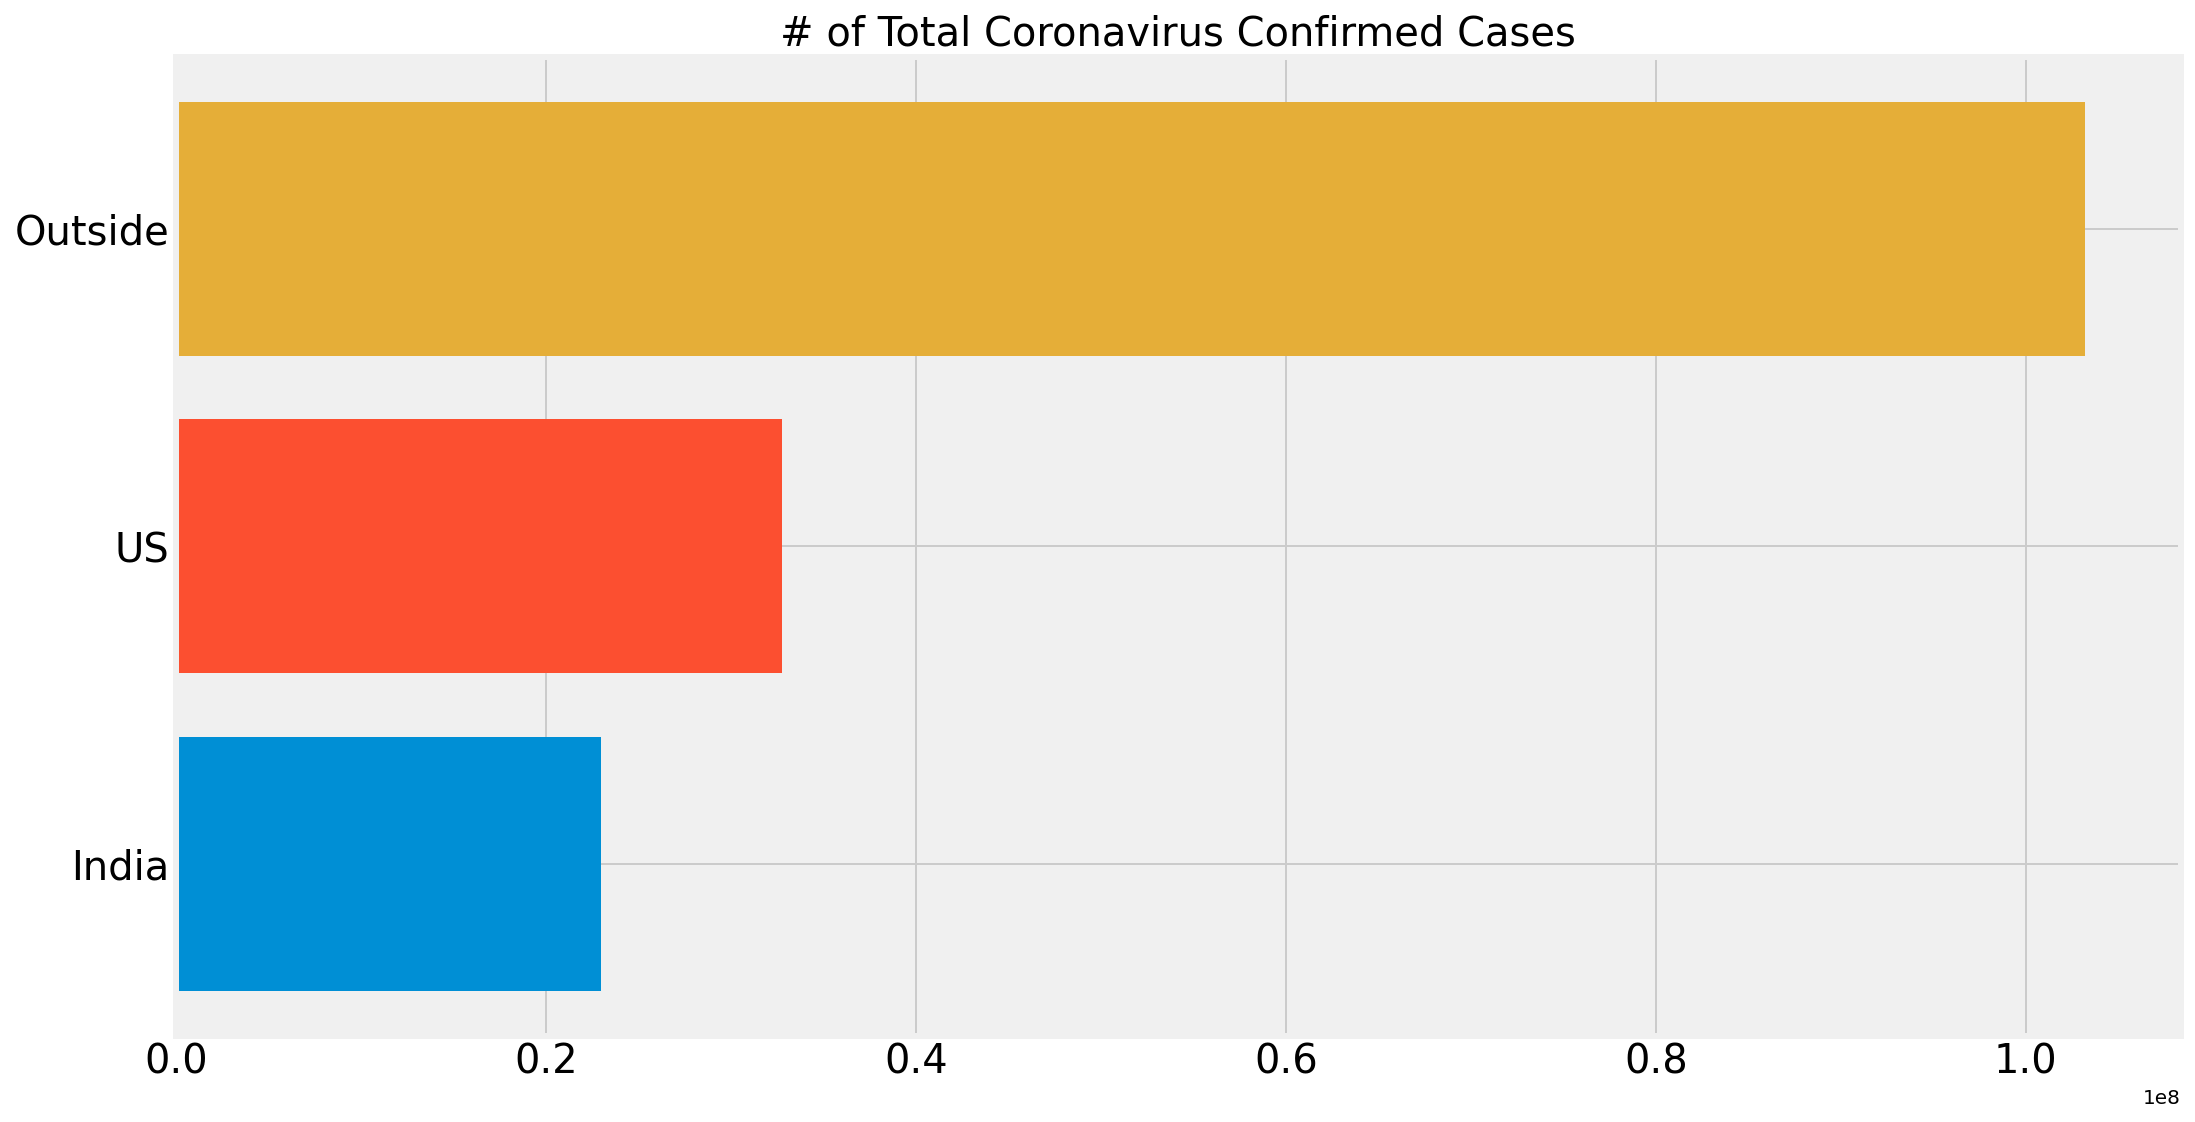

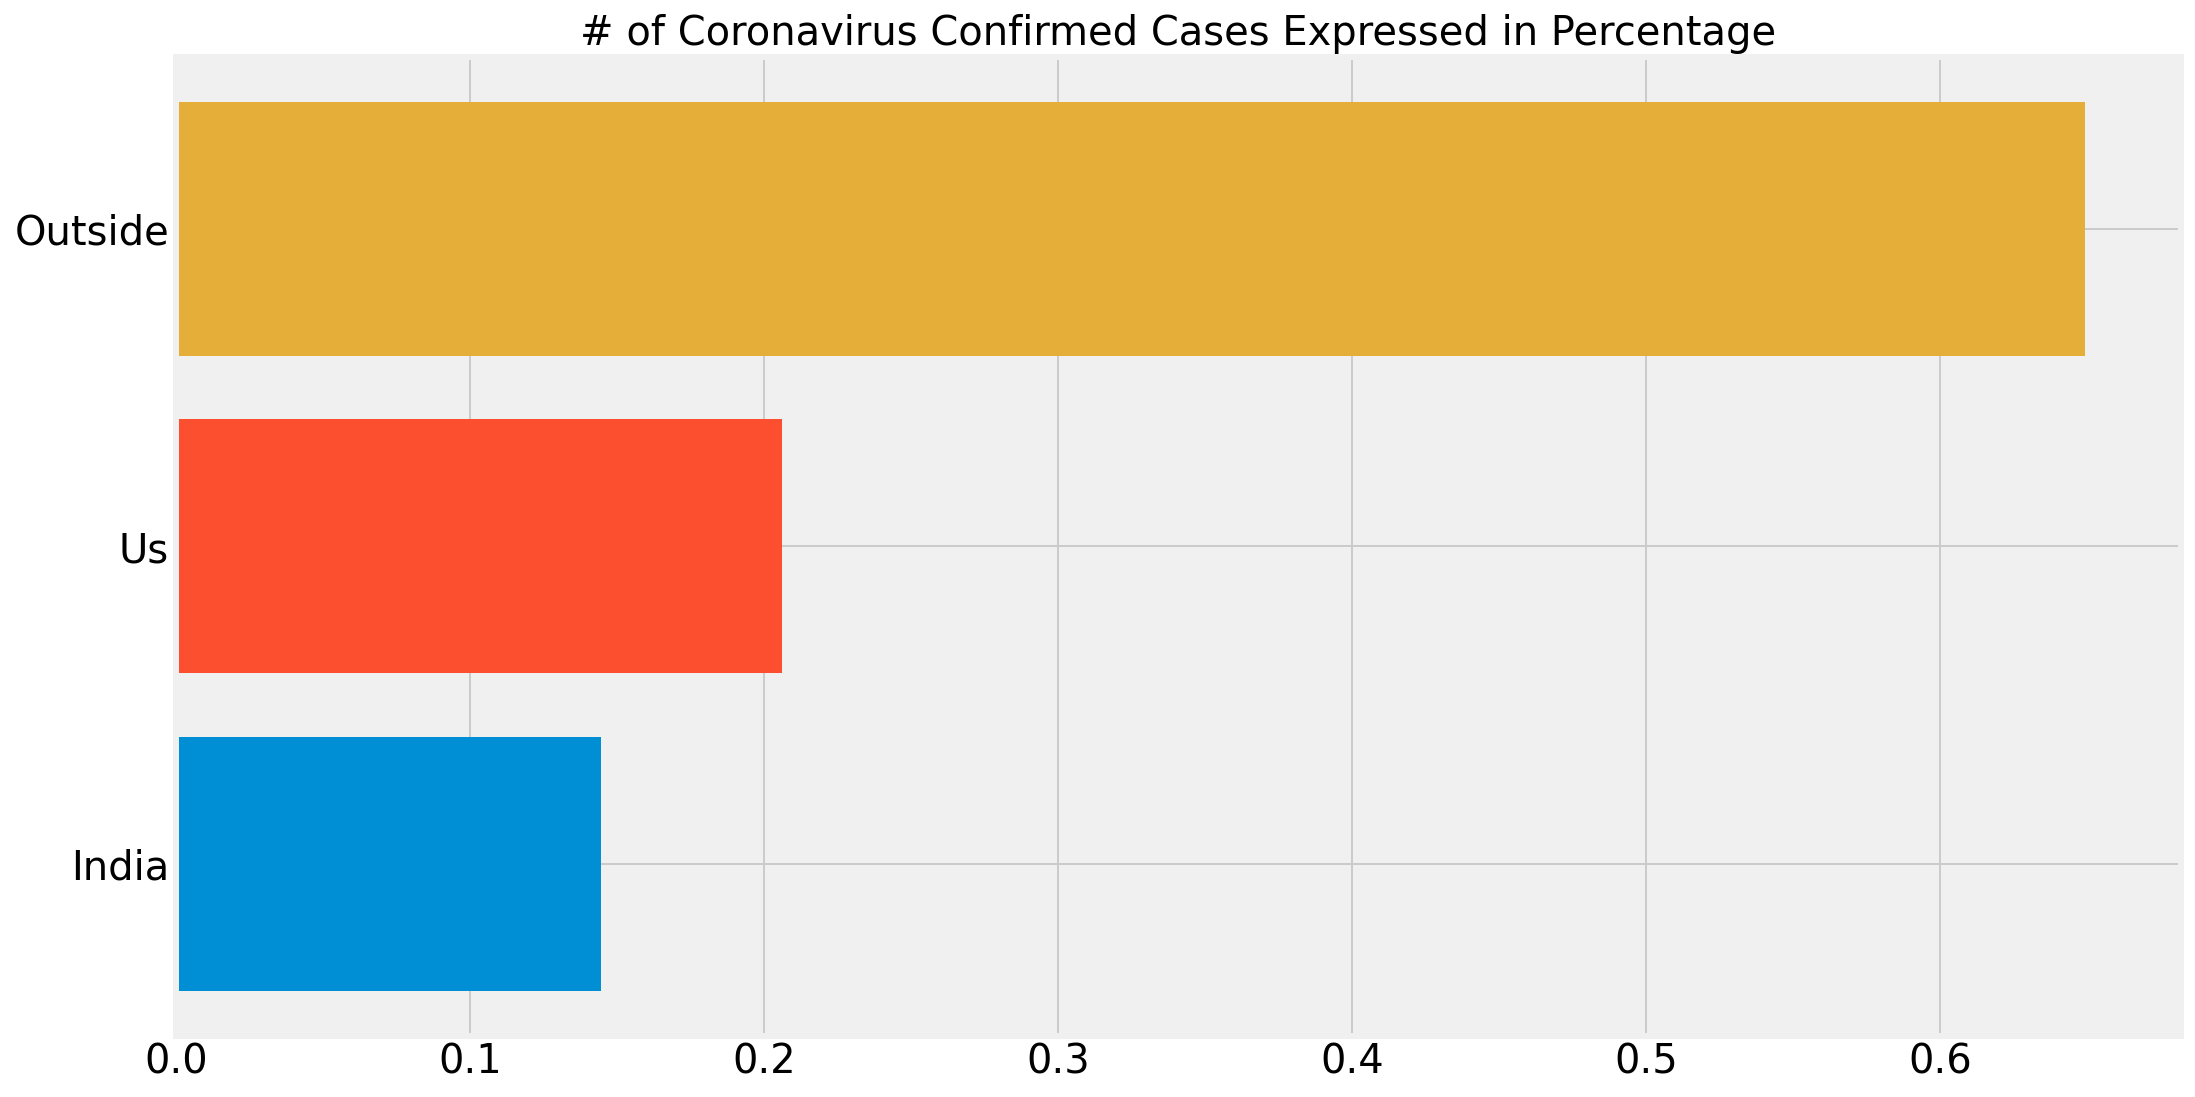

In [59]:
total_world_cases = np.sum(country_confirmed_cases)
india_confirmed = latest_data[latest_data['Country_Region']=='India']['Confirmed'].sum()
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_confirmed = total_world_cases - (india_confirmed + us_confirmed)

plt.figure(figsize=(16, 9))
plt.barh('India', india_confirmed)
plt.barh('US', us_confirmed)
plt.barh('Outside', outside_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


plt.figure(figsize=(16, 9))
plt.barh('India', india_confirmed/total_world_cases)
plt.barh('Us', us_confirmed/total_world_cases)
plt.barh('Outside', outside_confirmed/total_world_cases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [60]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [61]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    
# good for a lot x values 
def plot_bar_graphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

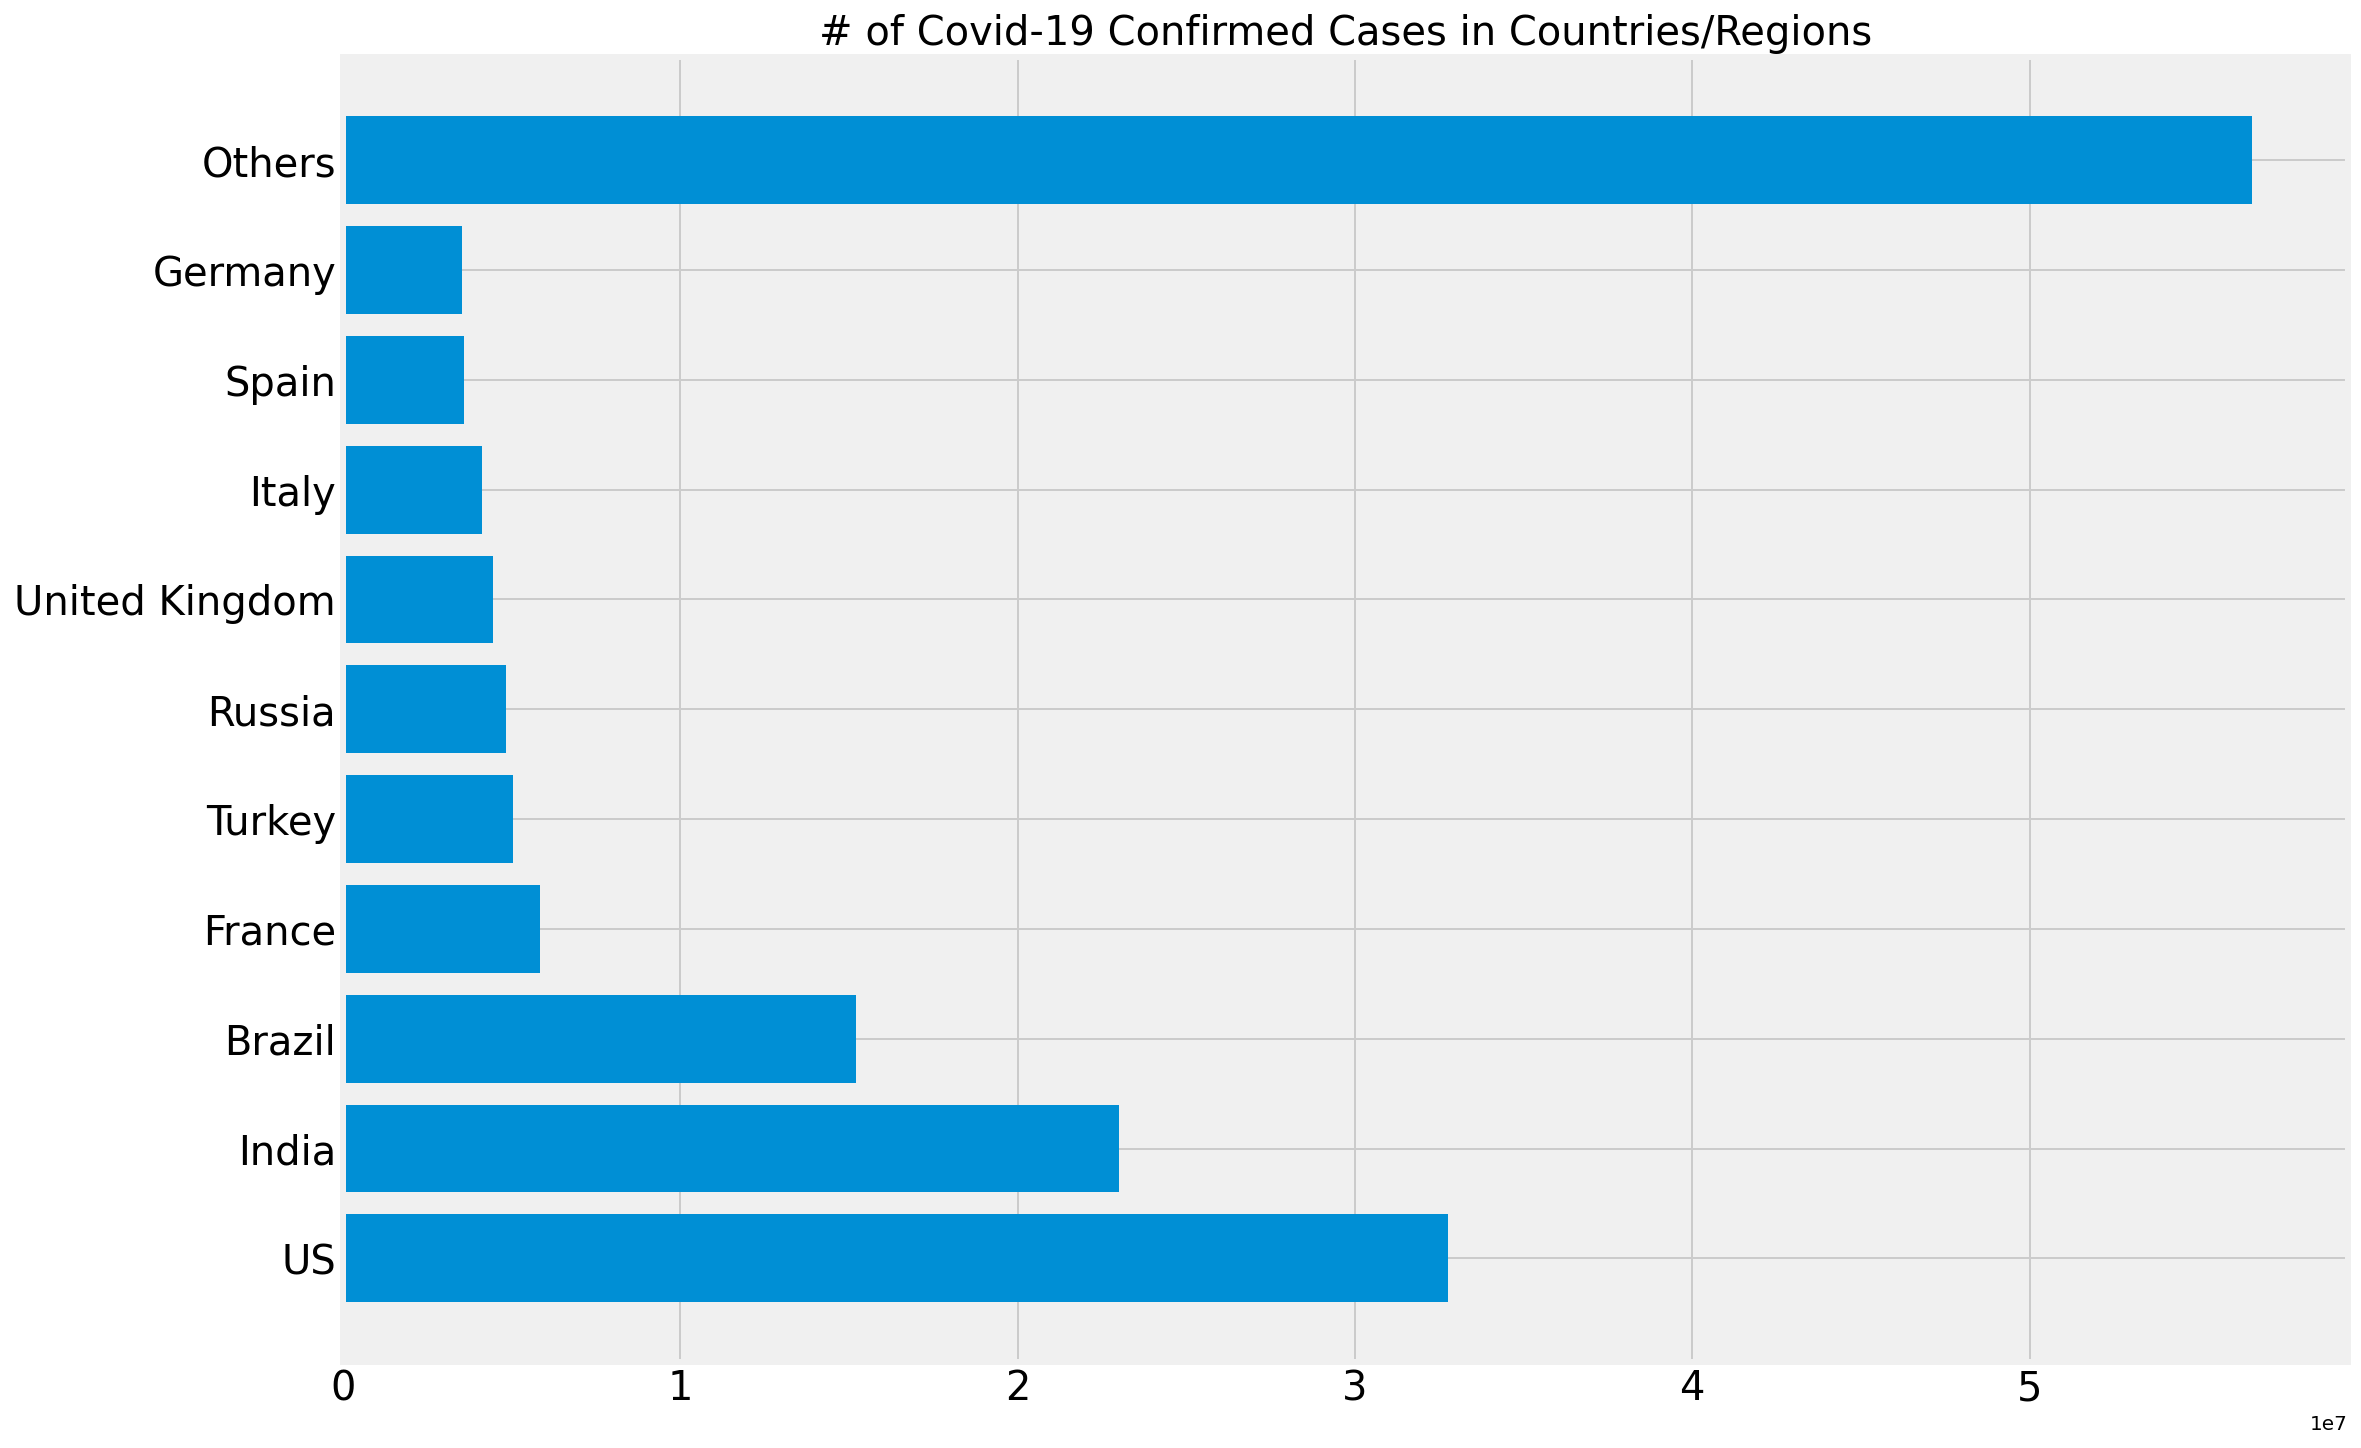

In [62]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

In [63]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True, labels=y)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

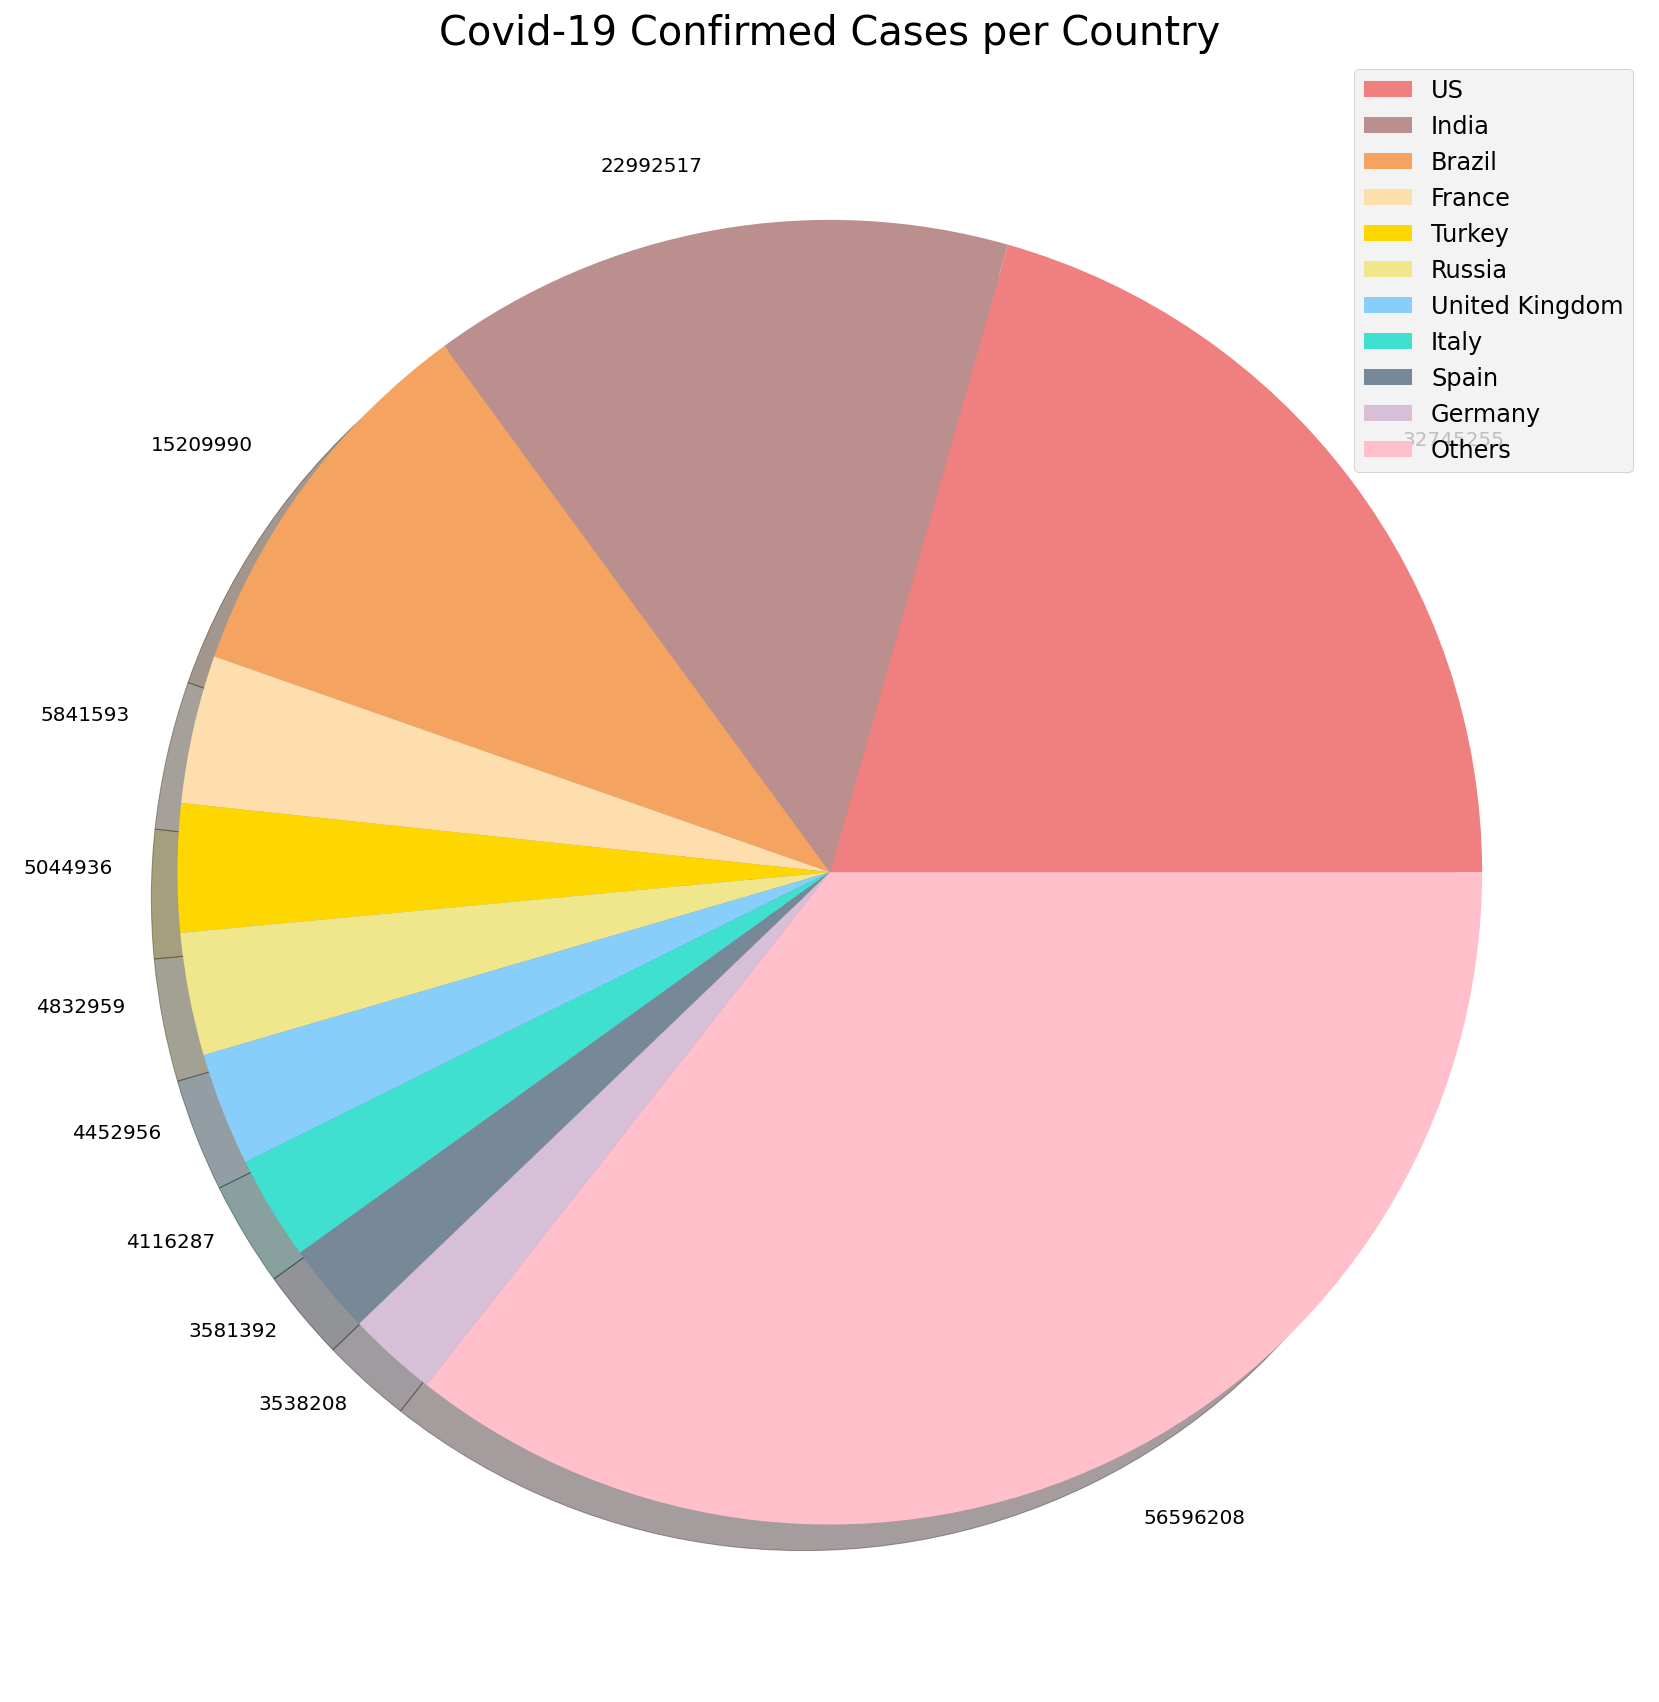

In [64]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')